In [1]:
! pip install -q kaggle  # Installing Kaggle package

In [2]:
! mkdir ~/.kaggle  # Create a directory named '.kaggle' in the home directory
! cp kaggle.json ~/.kaggle/  # Copy the 'kaggle.json' file to the '.kaggle' directory
! chmod 600 ~/.kaggle/kaggle.json  # Change the permissions of the 'kaggle.json' file
! kaggle datasets download -d pkdarabi/brain-tumor-image-dataset-semantic-segmentation  # Download the specified Kaggle dataset


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/pkdarabi/brain-tumor-image-dataset-semantic-segmentation
License(s): Attribution 4.0 International (CC BY 4.0)
 98% 82.0M/83.7M [00:01<00:00, 129MB/s] 
100% 83.7M/83.7M [00:01<00:00, 77.1MB/s]


In [3]:
# Create a folder named 'data_set' and extract the downloaded dataset into it
! mkdir data_set  # Create a directory named 'data_set'
! unzip -q brain-tumor-image-dataset-semantic-segmentation.zip -d data_set  # Extract the downloaded zip file into the 'data_set' directory

In [4]:
import torch
from torch import nn
from torchvision import datasets
from pathlib import Path
import os
from glob import glob
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
import json
import skimage.draw
import tifffile
import shutil


In [5]:
# device = "cuda" if torch.cuda.is_available else "cpu"
# device

In [6]:
with open('/content/data_set/valid/_annotations.coco.json','r') as data:
  data = json.load(data)


In [7]:
for image in data['images'][:5]:
  print(image['file_name'])

1997_jpg.rf.57e306420710246d04c0d5c26e6496c6.jpg
2422_jpg.rf.59a35b6d8d2eed150af8535cf09bbde5.jpg
1630_jpg.rf.5afc6e25d7987503a11bcb0791b60b53.jpg
1330_jpg.rf.5b23bf18a29b0f50e376b19a5a84f823.jpg
2768_jpg.rf.5b87c0023909e0789a33185a3aab92e9.jpg


In [8]:
for segmentation in data['annotations'][:5]:
   print(segmentation['segmentation'])

[[218.75, 300, 116.25, 300, 116.25, 443.75, 218.75, 443.75, 218.75, 300]]
[[380, 326.25, 235, 326.25, 235, 475, 380, 475, 380, 326.25]]
[[410, 245, 291.25, 245, 291.25, 360, 410, 360, 410, 245]]
[[296.25, 283.75, 222.5, 283.75, 222.5, 356.25, 296.25, 356.25, 296.25, 283.75]]
[[385, 161.25, 202.5, 161.25, 202.5, 523.75, 385, 523.75, 385, 161.25]]


In [9]:
def Draw_mask(dir_image_random, data):
    mask_images = []

    for i, img_r in enumerate(dir_image_random):
        # Read the image from the given path
        image = cv2.imread(img_r)

        # Find the corresponding image ID in the data dictionary by matching the file name
        image_ID = [image for image in data['images'] if os.path.basename(img_r) == image['file_name']][0]

        # Find the segmentation annotation for the image ID
        seg_ID = [ann for ann in data['annotations'] if ann['image_id'] == image_ID['id']][0]

        # Convert the segmentation points to a NumPy array of type int32
        point = np.array(seg_ID['segmentation'], np.int32)

        # Reshape the points to the required format for polylines function (5 points, 1 set of points, 2 coordinates per point)
        points = point.reshape(5, 1, 2)

        # Draw the polygon (segmentation mask) on the image with green color and a thickness of 2
        image_before_draw = cv2.polylines(image, [points], True, (0, 255, 0), 2)

        # Append the image with the drawn mask to the list
        mask_images.append(image_before_draw)

    # Create a figure for displaying the images
    plt.figure(figsize=(10, 10))

    for i in range(len(mask_images)):
        plt.subplot(5, 5, i+1)
        plt.imshow(mask_images[i])
        plt.axis('off')


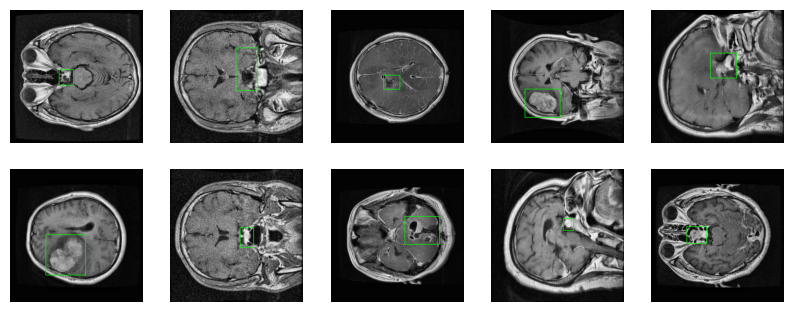

In [10]:
import random
import cv2
import matplotlib.pyplot as plt

images_dir = "/content/data_set/valid"
images_flie = [os.path.join(images_dir, img['file_name']) for img in data['images']]
dir_image_random = random.sample(images_flie,10)
Draw_mask(dir_image_random, data)

In [11]:
def create_mask(image_info, annotations, output_folder, max_print=3):

    mask_np = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)

    obj_number = 1
    printed_masks = 0

    for ann in annotations:
        # Check if the annotation corresponds to the current image.
        if image_info['id'] == ann['image_id']:
            # Iterate over each segmentation in the annotation.
            for seg_idx, seg in enumerate(ann['segmentation']):
                # Extract the x and y coordinates from the segmentation.
                rr, cc = skimage.draw.polygon(seg[1::2], seg[0::2], mask_np.shape)

                # Create a temporary mask for the current segmentation, initialized to zeros.
                seg_mask = np.zeros_like(mask_np, dtype=np.uint8)

                # Set the pixels within the polygon to 255 (white) in the temporary mask.
                seg_mask[rr, cc] = 255

                # Define the path to save the segmentation mask as a .tif file.
                mask_path = os.path.join(output_folder, f"{image_info['file_name'].replace('.jpg', '')}_seg_{seg_idx}.tif")

                # Save the segmentation mask to the specified path.
                tifffile.imwrite(mask_path, seg_mask)

                # Increment the count of printed masks.
                printed_masks += 1

                # If the maximum number of masks to print is reached, exit the function.
                if printed_masks >= max_print:
                    return  # Exit the function if maximum number of masks to print is reached



In [12]:
def main(json_file, mask_output_folder, image_output_folder, original_image_dir):

    with open(json_file, 'r') as f:
        data = json.load(f)

    images = data['images']
    annotations = data['annotations']

    # Create the mask output folder if it doesn't exist
    if not os.path.exists(mask_output_folder):
        os.makedirs(mask_output_folder)

    # Create the image output folder if it doesn't exist
    if not os.path.exists(image_output_folder):
        os.makedirs(image_output_folder)

    # Iterate over each image in the dataset
    for img in images:
        # Create the mask for the current image based on its annotations
        create_mask1 = create_mask(img, annotations, mask_output_folder)

        # Get the path to the original image
        original_image = os.path.join(original_image_dir, img['file_name'])

        # Define the new image path in the image output folder
        new_image_path = os.path.join(image_output_folder, os.path.basename(original_image))

        # Copy the original image to the new location
        shutil.copy2(original_image, new_image_path)


In [13]:
original_image_dir = '/content/data_set/test'  # Directory where the original test images are stored
json_file = '/content/data_set/test/_annotations.coco.json'  # Path to the COCO annotations JSON file for test images
mask_output_folder = '/content/data_set/test2/masks'  # Directory where the generated masks for test images will be saved
image_output_folder = '/content/data_set/test2/images'  # Directory where the processed test images will be saved
main(json_file, mask_output_folder, image_output_folder, original_image_dir)  # Call the main function to process test images

original_image_dir = '/content/data_set/train'  # Directory where the original training images are stored
json_file = '/content/data_set/train/_annotations.coco.json'  # Path to the COCO annotations JSON file for training images
mask_output_folder = '/content/data_set/train2/masks'  # Directory where the generated masks for training images will be saved
image_output_folder = '/content/data_set/train2/images'  # Directory where the processed training images will be saved
main(json_file, mask_output_folder, image_output_folder, original_image_dir)  # Call the main function to process training images

original_image_dir = '/content/data_set/valid'  # Directory where the original validation images are stored
json_file = '/content/data_set/valid/_annotations.coco.json'  # Path to the COCO annotations JSON file for validation images
mask_output_folder = '/content/data_set/valid2/masks'  # Directory where the generated masks for validation images will be saved
image_output_folder = '/content/data_set/valid2/images'  # Directory where the processed validation images will be saved
main(json_file, mask_output_folder, image_output_folder, original_image_dir)  # Call the main function to process validation images


In [14]:
def compare_folders(folder1, folder2):

    folder1_items = os.listdir(folder1)
    folder2_items = os.listdir(folder2)

    # Iterate over each item in folder1
    for item1 in folder1_items:
        f = False  # Initialize flag as False

        # Check if there is an item in folder2 that matches the first 5 characters of item1
        for j in folder2_items:
            if item1[:5] == j[:5]:
                f = True  # Set flag to True if a match is found
                break  # Exit the inner loop as match is found

        if not f:
            # If no match found, print the item and delete it from folder1
            print(f"This element {item1} not found.")
            item1_path = os.path.join(folder1, item1)
            os.remove(item1_path)
            print(f"Deleted {item1}")

    # Iterate over each item in folder2
    for item2 in folder2_items:
        f = False  # Initialize flag as False

        # Check if there is an item in folder1 that matches the first 5 characters of item2
        for j in folder1_items:
            if item2[:5] == j[:5]:
                f = True  # Set flag to True if a match is found
                break  # Exit the inner loop as match is found

        if not f:
            # If no match found, print the item and delete it from folder2
            print(f"This element {item2} not found.")
            item2_path = os.path.join(folder2, item2)
            os.remove(item2_path)
            print(f"Deleted {item2}")


In [15]:
images_path = "/content/data_set/train2/images"
mask_path = "/content/data_set/train2/masks"
compare_folders(images_path, mask_path)

This element 2369_jpg.rf.8b8afa9d79c61fa42ca128c940b9cbc0.jpg not found.
Deleted 2369_jpg.rf.8b8afa9d79c61fa42ca128c940b9cbc0.jpg


In [16]:
class CustomDataset:
    def __init__(self, root_dir):

        self.root = root_dir                                   # Initialize the dataset with the root directory

        self.image_f = os.path.join(root_dir, 'images')        # Define the path for the images folder

        self.mask_f = os.path.join(root_dir, 'masks')          # Define the path for the masks folder


        self.images = sorted(os.listdir(self.image_f))         # List all image files in the images folder and sort them

        self.masks = sorted(os.listdir(self.mask_f))           # List all mask files in the masks folder and sort them

    def __len__(self):

        return len(self.images)

    def __getitem__(self, index):

        # Get the image name and mask at the specified index
        img_name = self.images[index]
        mask_name = self.masks[index]


        # Get the full path of the image file
        img_path = os.path.join(self.image_f, img_name)
        # Read the image using OpenCV
        img = cv2.imread(img_path)
        # Convert the image from BGR (OpenCV default) to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Get the full path of the mask file
        mask_path = os.path.join(self.mask_f, mask_name)
        # Read the mask image in grayscale mode
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        return img, mask


In [17]:
dataset = CustomDataset("/content/data_set/test2")

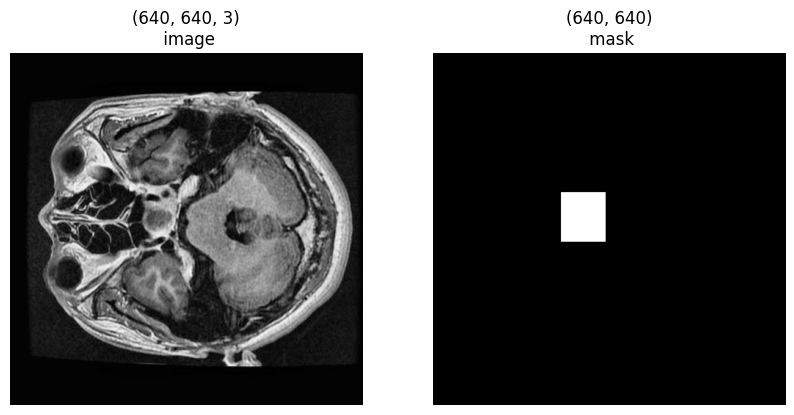

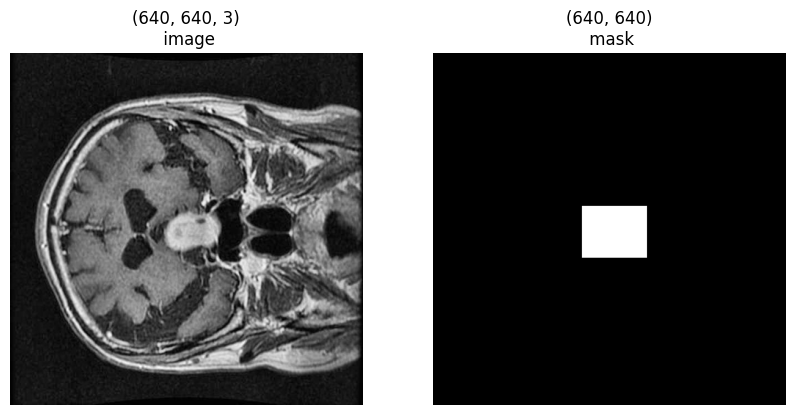

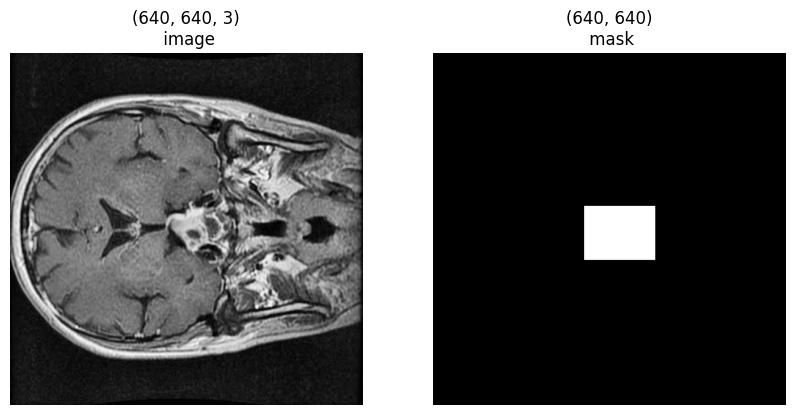

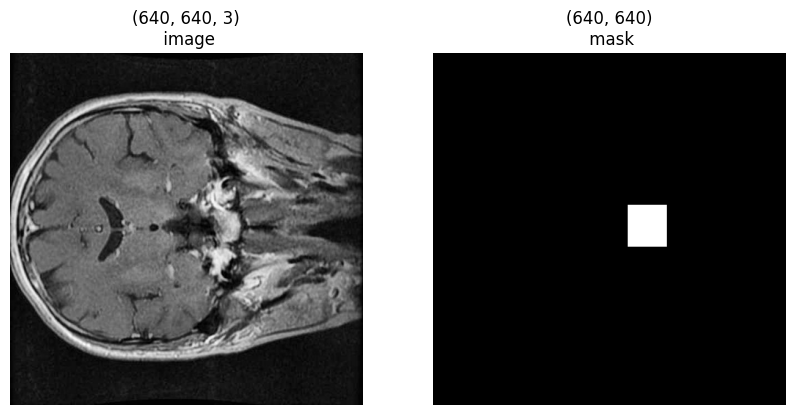

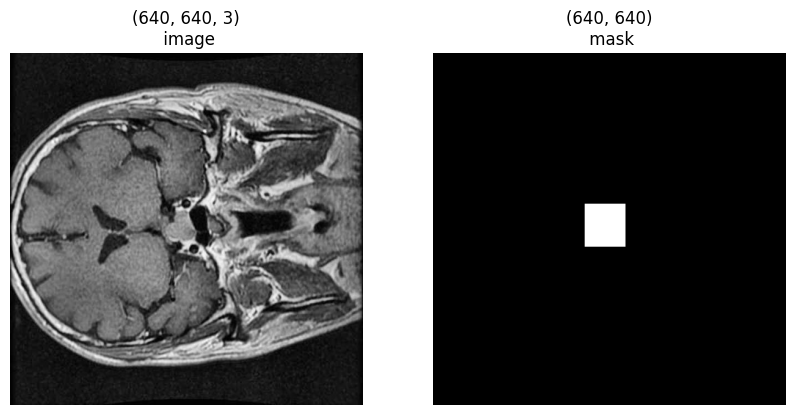

In [18]:

for i in range(5):
  img,mask = dataset[i]

  plt.figure(figsize=(10,10))

  plt.subplot(1, 2, 1)
  plt.imshow(img)
  plt.title(f'{img.shape}\n image');
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(mask,cmap='gray')
  plt.title(f'{mask.shape}\n mask');
  plt.axis('off')

In [19]:
class CustomDataset_General(Dataset):
    def __init__(self, data_dir, transform=None, data_size=None):
        # Initialize the dataset with directory, transformations, and data size
        self.data_dir = data_dir
        self.transform = transform

        # Define the path for the images folder
        self.imagefolder = os.path.join(data_dir, 'images')
        # Define the path for the masks folder
        self.maskfolder = os.path.join(data_dir, 'masks')

        # List and sort all image files, limit by data_size if provided
        self.imagefile = sorted(os.listdir(self.imagefolder)[:data_size])
        # List and sort all mask files, limit by data_size if provided
        self.maskfile = sorted(os.listdir(self.maskfolder)[:data_size])

    def __len__(self):
        # Return the number of images in the dataset
        return len(self.imagefile)

    def __getitem__(self, idx):
        # Get the image file name at the given index
        image_id = self.imagefile[idx]
        # Get the full path of the image file
        img_path = os.path.join(self.imagefolder, image_id)
        # Open the image and convert it to RGB
        image = Image.open(img_path).convert("RGB")
        # Convert the RGB image to grayscale
        image_G = image.convert("L")

        # Get the mask file name at the given index
        mask_id = self.maskfile[idx]
        # Get the full path of the mask file
        mask_path = os.path.join(self.maskfolder, mask_id)
        # Open the mask image and convert it to grayscale
        mask = Image.open(mask_path).convert("L")

        # Apply the transformation if it is provided
        if self.transform:
            image_G = self.transform(image_G)
            mask = self.transform(mask)

        # Return the grayscale image and its corresponding mask
        return image_G, mask


In [20]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),
    transforms.Lambda(lambda x: x.clamp(0, 1))
])


In [21]:
# path_dir the dataset
train_path = '/content/data_set/train2'
valid_path = '/content/data_set/valid2'
test_path = '/content/data_set/test2'


train_dataset = CustomDataset_General(train_path, transform=transform)
valid_dataset = CustomDataset_General(valid_path, transform=transform)
test_dataset = CustomDataset_General(test_path, transform=transform)
# train_dataset.__len__(), valid_dataset.__len__(), test_dataset.__len__()

In [22]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
imgs , masks = next(iter(train_loader))
imgs.shape , masks.shape

(torch.Size([16, 1, 224, 224]), torch.Size([16, 1, 224, 224]))

In [24]:
# Calculate the number of ones in the tensor imgs
num_ones_image = torch.eq(imgs, 1).sum().item()

# Calculate the number of zeros in the tensor imgs
num_zeros_image = imgs.numel() - num_ones_image

# Print the number of ones and zeros in the tensor imgs
print(num_ones_image, num_zeros_image)


30654 772162


In [25]:
# Calculate the number of ones in the tensor masks
num_ones_mask = torch.eq(masks, 1).sum().item()

# Calculate the number of zeros in the tensor masks
num_zeros_mask = masks.numel() - num_ones_mask

# Print the number of ones and zeros in the tensor masks
print(num_ones_mask, num_zeros_mask)


28350 774466


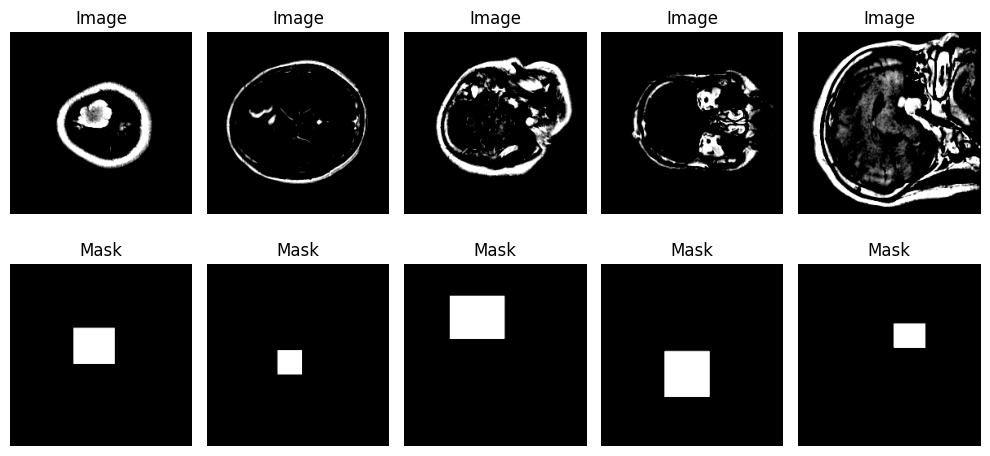

In [26]:
plt.figure(figsize=(10,5))

# Plot the first 5 images
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow(imgs[i].squeeze(0).numpy(),cmap='gray')
  plt.title('Image')
  plt.axis('off')

# Plot the corresponding masks for the first 5 images
for i in range(5):
  plt.subplot(2,5,i+6)
  plt.imshow(masks[i].squeeze(0).numpy(),cmap='gray')
  plt.title('Mask')
  plt.axis('off')


plt.tight_layout()
plt.show()  # Display the plot

#Build-Model-**U-Net**
It's used for **image segmentation** tasks

In [27]:
# from __future__ import print_function, division
import torch.nn.functional as F
import torch.utils.data

    # """
    # For more information, visit the website
    # https://arxiv.org/abs/1804.03999
    # """

class conv_block(nn.Module):

    def __init__(self, in_channel, out_channel):
        super(conv_block, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True))

    def forward(self, x):

        x = self.conv(x)
        return x


class up_conv(nn.Module):

    def __init__(self, in_channel, out_channel):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x


class Attention_block(nn.Module):


    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out


class Attention_UNet(nn.Module):


    def __init__(self, img_channel=3, output_channel=1):
        super(Attention_UNet, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_channel, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], output_channel, kernel_size=1, stride=1, padding=0)


    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)


        d5 = self.Up5(e5)
        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

        return out

In [28]:

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss,self).__init__()


    def forward(self,inputs,target):
        inputs = torch.sigmoid(inputs)
        smooth = 1.0
        inputs = inputs.reshape(-1)
        tar = target.reshape(-1)
        intersection = (inputs*tar).sum()

        dic_loss = 1-((2.0*intersection+smooth)/(inputs.sum()+tar.sum()+smooth))

        return dic_loss
class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss,self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE



In [29]:
path_save = "file/"
if not os.path.exists(path_save):
    os.makedirs(path_save)

In [30]:
checkpoints_path = "file/checkpoints.pth"
num_epochs = 50
lr=1e-3

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
loss_fn = DiceBCELoss()

In [33]:
model = Attention_UNet(1,1)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

In [34]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model,input_size=(1,1,224,224)) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
Attention_UNet                           [1, 1, 224, 224]          --
├─conv_block: 1-1                        [1, 64, 224, 224]         --
│    └─Sequential: 2-1                   [1, 64, 224, 224]         --
│    │    └─Conv2d: 3-1                  [1, 64, 224, 224]         640
│    │    └─BatchNorm2d: 3-2             [1, 64, 224, 224]         128
│    │    └─ReLU: 3-3                    [1, 64, 224, 224]         --
│    │    └─Conv2d: 3-4                  [1, 64, 224, 224]         36,928
│    │    └─BatchNorm2d: 3-5             [1, 64, 224, 224]         128
│    │    └─ReLU: 3-6                    [1, 64, 224, 224]         --
├─MaxPool2d: 1-2                         [1, 64, 112, 112]         --
├─conv_block: 1-3                        [1, 128, 112, 112]        --
│    └─Sequential: 2-2                   [1, 128, 112, 112]        --
│    │    └─Conv2d: 3-7                  [1, 128, 112, 112]        73,856
│   

In [35]:
from tqdm import tqdm
def train(model,optimizer,loss_fn,loader,device):
    epoch_loss =0.0
    model.train()

    for x,y in tqdm(loader):
        x = x.to(device,dtype = torch.float32)
        y = y.to(device, dtype = torch.float32)
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred,y)
        loss.backward()
        optimizer.step()
        epoch_loss +=loss.item()

    return epoch_loss/len(loader)



In [36]:
def valid(model,loss_fn,loader,device):
    epoch_loss = 0.0
    model.eval()

    for x,y in loader:
        x = x.to(device,dtype = torch.float32)
        y = y.to(device, dtype = torch.float32)
        pred = model(x)
        loss = loss_fn(pred,y)
        epoch_loss +=loss.item()
    return epoch_loss/len(loader)

In [37]:
from IPython.display import clear_output
best_val_loss = float('inf')
train_losses = []
cross_losses = []
for epoch in range(num_epochs):
    train_loss = train(model,optimizer,loss_fn,train_loader,device)
    val_loss = valid(model,loss_fn,val_loader,device)
    train_losses.append(train_loss)
    cross_losses.append(val_loss)


    print(f'Epoch : {epoch+1} | train loss : {train_loss:.4f} | val loss : {val_loss:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), checkpoints_path)


  0%|          | 0/94 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 94/94 [01:29<00:00,  1.05it/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to

Epoch : 1 | train loss : 1.0941 | val loss : 1.9519


100%|██████████| 94/94 [01:28<00:00,  1.06it/s]


Epoch : 2 | train loss : 0.7799 | val loss : 0.9121


100%|██████████| 94/94 [01:30<00:00,  1.04it/s]


Epoch : 3 | train loss : 0.6518 | val loss : 0.6597


100%|██████████| 94/94 [01:30<00:00,  1.04it/s]


Epoch : 4 | train loss : 0.5885 | val loss : 0.7375


100%|██████████| 94/94 [01:31<00:00,  1.03it/s]


Epoch : 5 | train loss : 0.5546 | val loss : 0.7814


100%|██████████| 94/94 [01:31<00:00,  1.02it/s]


Epoch : 6 | train loss : 0.5270 | val loss : 0.6535


100%|██████████| 94/94 [01:31<00:00,  1.02it/s]


Epoch : 7 | train loss : 0.5005 | val loss : 0.5896


100%|██████████| 94/94 [01:32<00:00,  1.02it/s]


Epoch : 8 | train loss : 0.4783 | val loss : 0.6251


100%|██████████| 94/94 [01:31<00:00,  1.03it/s]


Epoch : 9 | train loss : 0.4673 | val loss : 0.5282


100%|██████████| 94/94 [01:31<00:00,  1.03it/s]


Epoch : 10 | train loss : 0.4373 | val loss : 0.5587


100%|██████████| 94/94 [01:31<00:00,  1.02it/s]


Epoch : 11 | train loss : 0.4140 | val loss : 0.5045


100%|██████████| 94/94 [01:32<00:00,  1.02it/s]


Epoch : 12 | train loss : 0.3952 | val loss : 0.4995


100%|██████████| 94/94 [01:31<00:00,  1.03it/s]


Epoch : 13 | train loss : 0.3853 | val loss : 0.5523


100%|██████████| 94/94 [01:32<00:00,  1.02it/s]


Epoch : 14 | train loss : 0.3814 | val loss : 0.4765


100%|██████████| 94/94 [01:32<00:00,  1.02it/s]


Epoch : 15 | train loss : 0.3652 | val loss : 0.5225


100%|██████████| 94/94 [01:32<00:00,  1.02it/s]


Epoch : 16 | train loss : 0.3549 | val loss : 0.4774


100%|██████████| 94/94 [01:32<00:00,  1.02it/s]


Epoch : 17 | train loss : 0.3382 | val loss : 0.4555


100%|██████████| 94/94 [01:32<00:00,  1.01it/s]


Epoch : 18 | train loss : 0.3179 | val loss : 0.4633


100%|██████████| 94/94 [01:32<00:00,  1.02it/s]


Epoch : 19 | train loss : 0.3104 | val loss : 0.4488


100%|██████████| 94/94 [01:31<00:00,  1.02it/s]


Epoch : 20 | train loss : 0.2927 | val loss : 0.4257


100%|██████████| 94/94 [01:31<00:00,  1.02it/s]


Epoch : 21 | train loss : 0.2805 | val loss : 0.4554


100%|██████████| 94/94 [01:31<00:00,  1.02it/s]


Epoch : 22 | train loss : 0.2668 | val loss : 0.4330


100%|██████████| 94/94 [01:31<00:00,  1.03it/s]


Epoch : 23 | train loss : 0.2511 | val loss : 0.4243


100%|██████████| 94/94 [01:31<00:00,  1.02it/s]


Epoch : 24 | train loss : 0.2474 | val loss : 0.4653


100%|██████████| 94/94 [01:31<00:00,  1.02it/s]


Epoch : 25 | train loss : 0.2449 | val loss : 0.4733


100%|██████████| 94/94 [01:31<00:00,  1.02it/s]


Epoch : 26 | train loss : 0.2299 | val loss : 0.4912


100%|██████████| 94/94 [01:31<00:00,  1.02it/s]


Epoch : 27 | train loss : 0.2197 | val loss : 0.4345


100%|██████████| 94/94 [01:32<00:00,  1.02it/s]


Epoch : 28 | train loss : 0.2027 | val loss : 0.4230


100%|██████████| 94/94 [01:31<00:00,  1.02it/s]


Epoch : 29 | train loss : 0.1853 | val loss : 0.4191


100%|██████████| 94/94 [01:32<00:00,  1.02it/s]


Epoch : 30 | train loss : 0.1822 | val loss : 0.4461


100%|██████████| 94/94 [01:32<00:00,  1.02it/s]


Epoch : 31 | train loss : 0.1797 | val loss : 0.4549


100%|██████████| 94/94 [01:31<00:00,  1.03it/s]


Epoch : 32 | train loss : 0.1743 | val loss : 0.4485


100%|██████████| 94/94 [01:31<00:00,  1.02it/s]


Epoch : 33 | train loss : 0.1598 | val loss : 0.4550


100%|██████████| 94/94 [01:34<00:00,  1.00s/it]


Epoch : 34 | train loss : 0.1497 | val loss : 0.4277


100%|██████████| 94/94 [01:31<00:00,  1.02it/s]


Epoch : 35 | train loss : 0.1449 | val loss : 0.4238


100%|██████████| 94/94 [01:32<00:00,  1.02it/s]


Epoch : 36 | train loss : 0.1321 | val loss : 0.4436


100%|██████████| 94/94 [01:32<00:00,  1.02it/s]


Epoch : 37 | train loss : 0.1271 | val loss : 0.4641


100%|██████████| 94/94 [01:32<00:00,  1.02it/s]


Epoch : 38 | train loss : 0.1292 | val loss : 0.4800


100%|██████████| 94/94 [01:32<00:00,  1.02it/s]


Epoch : 39 | train loss : 0.1317 | val loss : 0.4304


100%|██████████| 94/94 [01:31<00:00,  1.02it/s]


Epoch : 40 | train loss : 0.1244 | val loss : 0.4649


100%|██████████| 94/94 [01:31<00:00,  1.02it/s]


Epoch : 41 | train loss : 0.1135 | val loss : 0.4387


100%|██████████| 94/94 [01:32<00:00,  1.02it/s]


Epoch : 42 | train loss : 0.1091 | val loss : 0.4409


100%|██████████| 94/94 [01:32<00:00,  1.02it/s]


Epoch : 43 | train loss : 0.1005 | val loss : 0.4552


100%|██████████| 94/94 [01:32<00:00,  1.02it/s]


Epoch : 44 | train loss : 0.0939 | val loss : 0.4620


100%|██████████| 94/94 [01:31<00:00,  1.02it/s]


Epoch : 45 | train loss : 0.0882 | val loss : 0.4485


100%|██████████| 94/94 [01:31<00:00,  1.02it/s]


Epoch : 46 | train loss : 0.0810 | val loss : 0.4619


100%|██████████| 94/94 [01:32<00:00,  1.02it/s]


Epoch : 47 | train loss : 0.0767 | val loss : 0.4964


100%|██████████| 94/94 [01:32<00:00,  1.02it/s]


Epoch : 48 | train loss : 0.0733 | val loss : 0.4801


100%|██████████| 94/94 [01:32<00:00,  1.02it/s]


Epoch : 49 | train loss : 0.0793 | val loss : 0.4766


100%|██████████| 94/94 [01:32<00:00,  1.02it/s]


Epoch : 50 | train loss : 0.0975 | val loss : 0.4785


In [59]:
model_path = '/content/file/checkpoints.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [65]:
model.to(device)
model.eval()

Attention_UNet(
  (Maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1

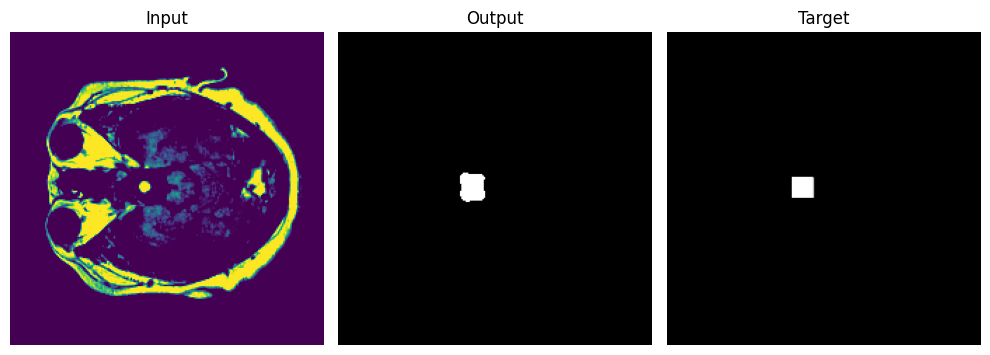

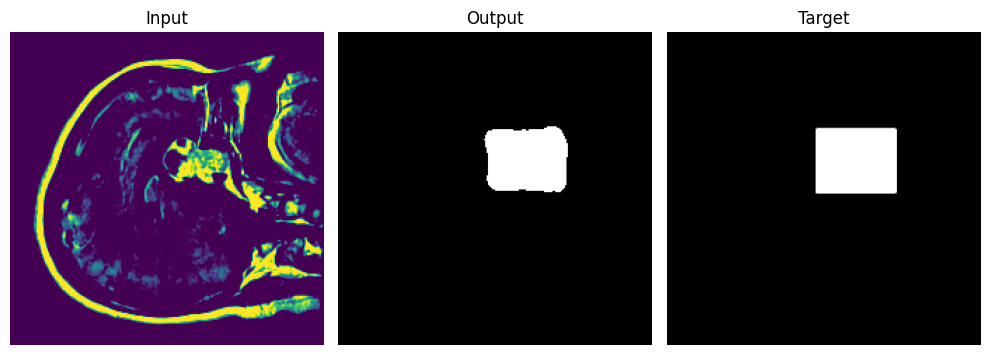

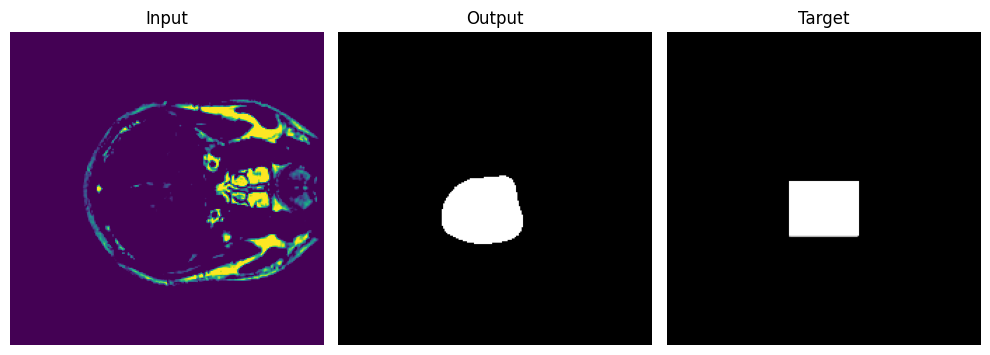

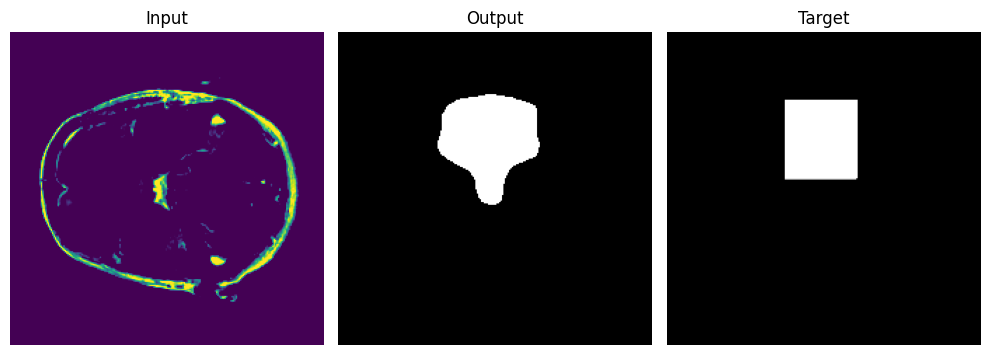

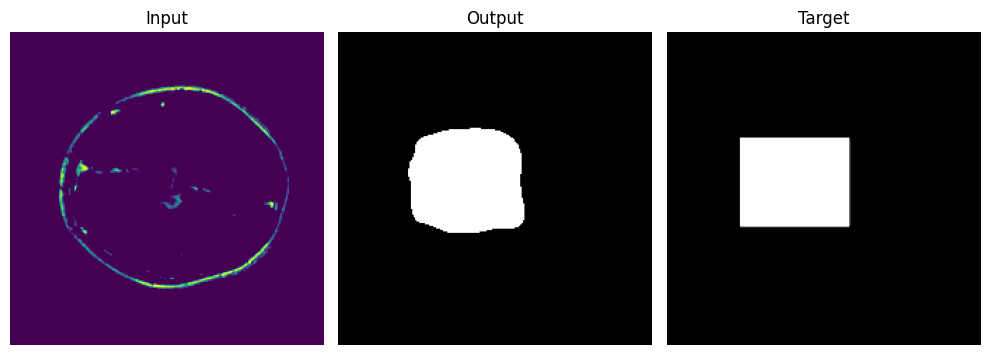

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 884.00 MiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,


In [62]:
i = 0

for x,y in test_loader:
    x  =x.to(device,dtype = torch.float32)
    y = y.to(device,dtype = torch.float32)

    pred = model(x)
    y_pred = (pred>0.5).float()



    if i < 5 :

      plt.figure(figsize=(10,5))

      plt.subplot(1, 3, 1)
      plt.imshow(x[0][0].cpu())
      plt.title("Input")
      plt.axis('off')

      plt.subplot(1, 3, 2)
      plt.imshow(y_pred[0][0].cpu(),cmap='gray')
      plt.title("Output")
      plt.axis('off')


      plt.subplot(1, 3, 3)
      plt.imshow(y[0][0].cpu(),cmap='gray')
      plt.title("Target")
      plt.axis('off')


      plt.tight_layout()
      plt.show()
      i +=1
